In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1.数据预处理

1.1 我们首先在原数据集增加一个叫“date”的属性，以格式‘%Y-%m-%d’记录日期，并保存为csv文件；然后将数据集中的NA转换为NAN，再去除               

In [2]:
pm25_data = pd.read_csv('PRSA_data.csv')
pm25_data.replace('NA',np.nan)
pm25_data = pd.get_dummies(pm25_data)
pm25_data['date'] = pm25_data['year'].astype(str) + '-' + pm25_data['month'].astype(str) + '-' + pm25_data['day'].astype(str)

#以'%Y-%m-%d'记录日期
for i in range(len(pm25_data)):
    pm25_data.loc[i,'date'] = pd.to_datetime(pm25_data.loc[i,'date']).strftime('%Y-%m-%d')
pm25_data.to_csv("pm25_data.csv",index=False)

# 去除NAN
pm25_data_dropna=pm25_data.dropna(axis=0, how='any', inplace=False) 

1.2 观察pm2.5的分布情况

Skewness: 1.802311
Kurtosis: 4.768933


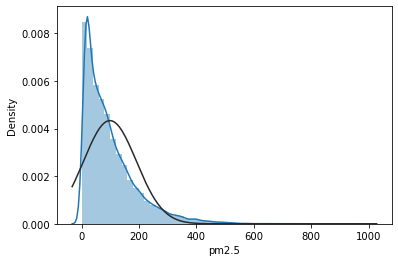

In [3]:
from scipy import stats
sns.distplot(pm25_data_dropna['pm2.5'], fit=stats.norm)
print("Skewness: %f" % pm25_data_dropna['pm2.5'].skew())
print("Kurtosis: %f" % pm25_data_dropna['pm2.5'].kurt())

1.3 从图中发现数据严重左偏，所以尝试用对数转换pm2.5，得到一个近似正态分布的数据。  
我们首先检查pm2.5有无0值

In [4]:
pm25_data_dropna[pm25_data_dropna['pm2.5']==0]

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,date
24034,24035,2012,9,28,10,0.0,-5,20.0,1020.0,139.48,0,0,0,1,0,0,2012-09-28
24039,24040,2012,9,28,15,0.0,-10,24.0,1017.0,192.68,0,0,0,1,0,0,2012-09-28


我们去除掉pm2.5为0的数据，能够这样做的原因是现实中几乎不可能出现pm2.5为0的情况

In [5]:
pm25_data_dropna = pm25_data_dropna.drop(pm25_data_dropna[pm25_data_dropna['pm2.5'] == 0].index).reset_index(drop=True)

1.4 检查对数转换后pm2.5的分布与正态分布的相似度

Skewness: -0.356563
Kurtosis: -0.563840


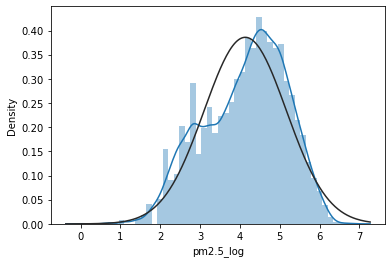

In [6]:
pm25_data_dropna['pm2.5_log'] = np.log(pm25_data_dropna['pm2.5']) 
sns.distplot(pm25_data_dropna['pm2.5_log'], fit=stats.norm)
print("Skewness: %f" % pm25_data_dropna['pm2.5_log'].skew())
print("Kurtosis: %f" % pm25_data_dropna['pm2.5_log'].kurt())

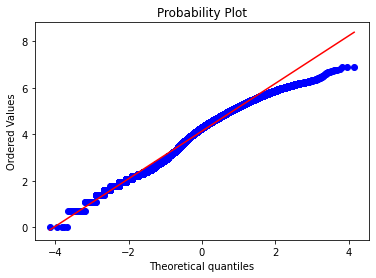

In [7]:
res = stats.probplot(pm25_data_dropna['pm2.5_log'], plot=plt)

从p-p图中可以看出对数转换后的pm2.5近似服从正态分布

1.5 获得训练集和测试集数据

In [8]:
# 测试数据日期
test_date=pd.date_range(start='2010-01-07',freq='W-Thu',end='2014-12-25').strftime('%Y-%m-%d').tolist()

# 测试数据索引
test_index=[]
for i in range(len(pm25_data_dropna['date'])):
    if pm25_data_dropna.iloc[i,-2] in test_date:
        test_index.append(i)

# 测试集和训练集
test_data=pm25_data_dropna.iloc[test_index,:].reset_index(drop=True)
train_data=pm25_data_dropna.drop(index=pm25_data_dropna.index[test_index]).reset_index(drop=True)

# 2.模型建立

2.1 我们选择用xgboost regressor拟合对数转换后的数据

In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

通过不断的调参，我们最终选择 XGBRegressor(learning_rate=0.1, n_estimators=600, max_depth=5)

In [10]:
var=['year','month','day','hour','DEWP','TEMP','PRES','Iws','Is','Ir','cbwd_NE','cbwd_NW','cbwd_SE','cbwd_cv'] # feature
X_train = train_data[var]
X_test = test_data[var]
y_train = train_data['pm2.5_log']
y_test = test_data['pm2.5']

XGB_model=xgb.XGBRegressor(learning_rate=0.1,n_estimators=600,max_depth=5)
XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)
y_pred = np.round(np.exp(y_pred)) 

#使用min_max归一化
y_pred=preprocessing.minmax_scale(y_pred)
y_test=preprocessing.minmax_scale(y_test)
print("Mean squared error of test data: %.4f" % mean_squared_error(y_pred, y_test))
print("R2 score of test data: %.4f" % XGB_model.score(X_test,test_data['pm2.5_log']))  

Mean squared error of test data: 0.0084
R2 score of test data: 0.7100


我们在测试集上预测 pm2.5，然后将得到的预测数据做指数变换得到 y_pred；将 y_pred 与真实数据 y_test 作 min_max 归一化，再计算它们的 MSE，我们得到的结果是0.0084。  
该模型的 R2 系数是0.7100

# 3.特征选择

3.1 通过XGB.feature_importances_选择特征

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

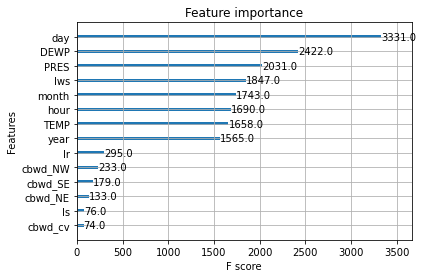

In [11]:
xgb.plot_importance(XGB_model)

从图中我们看出在所有特征中 day 的重要性最高；在气象特征中，DEWP、PRES、Iws、TEMP的重要性较高

3.2 通过corrmatrix选择特征

In [12]:
X=pm25_data_dropna[['year','month','day','hour','pm2.5','DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']]

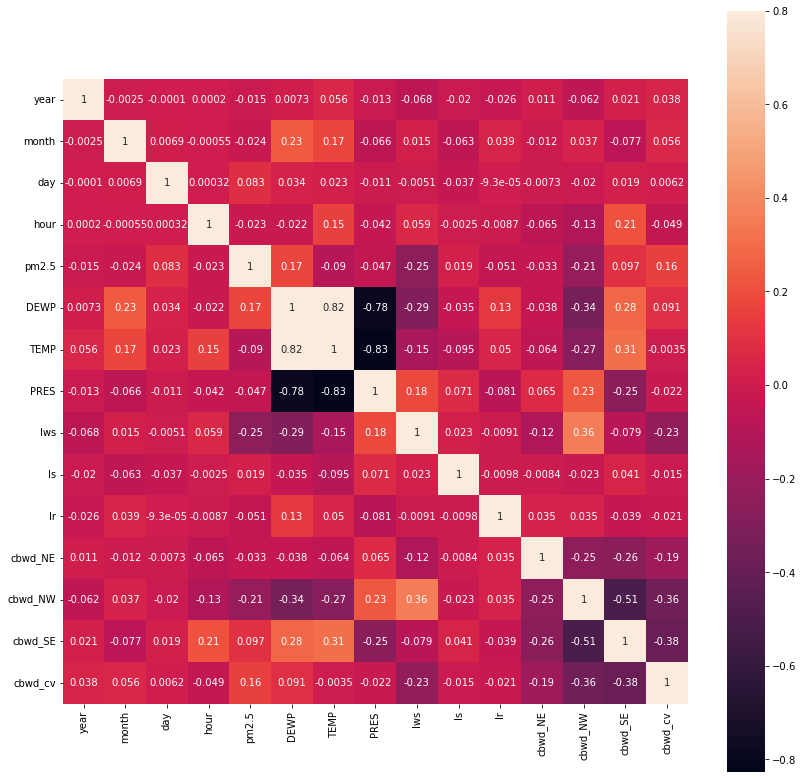

In [13]:
corrmatrix = X.corr()
plt.subplots(figsize=(14, 14))
sns.heatmap(corrmatrix, vmax=0.8, square=True, annot=True)
plt.show()

从图中可以看出DEWP、TEMP、Iws、cbwd_NW、cbwd_SE、cbwd_cv与pm2.5的相关性较高

3.3 通过PCA.explained_variance_ratio_选择特征

the explained varaince ratio is 
[0.81209615 0.93618929 0.96136072 0.97843113 0.9886945  0.99497762
 0.99832777 0.99897539 0.99960645 0.99980002 0.99988718 0.99995742
 1.         1.        ]


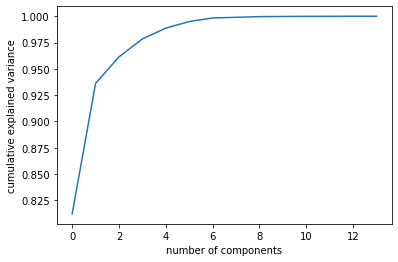

In [14]:
from sklearn.decomposition import PCA
pca=PCA().fit(X.drop('pm2.5',axis=1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print('the explained varaince ratio is ')
print(np.cumsum(pca.explained_variance_ratio_))

从图中我们可以看出可以取前3个主成分作为特征，其中第一主成分主要反映了对pm2.5的影响

In [15]:
print('the first 3 components are ')
print(pca.components_[0:3])

the first 3 components are 
[[-1.94127059e-03  3.66933583e-04 -1.15667395e-03  8.01431277e-03
  -9.65692716e-02 -4.62786970e-02  4.47759939e-02  9.93197460e-01
   3.91279118e-04 -3.93537967e-04 -7.13078920e-04  3.46430387e-03
  -8.75300585e-04 -1.87592436e-03]
 [-5.46047674e-04 -3.60771978e-02 -1.45995574e-02 -2.85262641e-02
  -6.62110654e-01 -5.78009979e-01  4.61010400e-01 -1.11894658e-01
   2.50792936e-03 -7.04886093e-03  1.48684588e-03  5.17502197e-03
  -7.00710031e-03  3.45232463e-04]
 [-3.31100204e-04  3.02658550e-03  9.99091104e-01 -1.11871522e-02
   1.65822401e-02 -1.77541195e-02  3.29017954e-02  5.57886593e-04
  -2.97490127e-03 -1.50471076e-04 -1.46044851e-04 -5.96526140e-04
   3.81852153e-04  3.60718838e-04]]
